In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno
import pickle

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectPercentile
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTEN
from imblearn.under_sampling import NearMiss
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score

In [2]:
survey = pd.read_csv('./adult19.csv')
survey.head()

,URBRRL,RATCAT_A,INCGRP_A,INCTCFLG_A,FAMINCTC_A,IMPINCFLG_A,PPSU,PSTRAT,HISPALLP_A,RACEALLP_A,...,PROXYREL_A,PROXY_A,AVAIL_A,HHSTAT_A,INTV_QRT,RECTYPE,WTFA_A,WTIA_A,HHX,POVRATTC_A
0,4,9,3,0,60000,2,2,122,3,2,...,NaN,NaN,1,1,1,10,13177.008,7601.336,H048109,2.96
1,4,9,3,0,50000,0,2,122,2,1,...,NaN,NaN,1,1,1,10,6140.552,3344.434,H027044,2.97
2,4,12,3,0,65000,1,2,122,2,1,...,NaN,NaN,1,1,1,10,9191.061,6949.498,H058855,4.28
3,4,14,5,0,120000,0,2,122,1,8,...,NaN,NaN,1,1,1,10,7900.035,6446.327,H031993,7.13
4,1,4,1,0,30000,0,2,115,2,1,...,NaN,NaN,1,1,1,10,10875.772,8646.586,H007122,1.13


In [4]:
# diabetes value counts
survey['DIBEV_A'].value_counts(normalize=True) 

2    0.893646
1    0.104854
7    0.001094
9    0.000406
Name: DIBEV_A, dtype: float64

In [6]:
survey['DIBEV_A'].count()

31997

In [7]:
# finding columns with more than half of values missing and dropping them
most_nulls = [column for column in survey.columns if survey[column].isnull().sum() > 16_000]
survey.drop(columns=most_nulls, inplace=True)

In [12]:
# changing no values in target column from 2 to 0
survey['DIBEV_A'] = survey['DIBEV_A'].replace(2, 0)
# dropping rows that aren't yes or no in target column
target_unknown = survey.query('DIBEV_A == 9 or DIBEV_A == 7')
survey.drop(target_unknown.index, inplace=True)

In [13]:
survey['DIBEV_A'].count()

31949

In [14]:
survey['DIBEV_A'].value_counts(normalize=True)

0    0.894989
1    0.105011
Name: DIBEV_A, dtype: float64

In [15]:
# changing datatypes for all columns except the target to objects so they can be dummified since they are categorical values
survey = survey.astype(object)
survey['DIBEV_A'] = survey['DIBEV_A'].astype(int)

In [16]:
# defining X and y variables for modeling
X = survey.drop(columns=['DIBEV_A', 'HHX'])
y = survey['DIBEV_A']

In [17]:
# dummifying X variable features
X_dum = pd.get_dummies(X, drop_first=True)

In [18]:
# choosing top 10 best predicting columns for modeling
kb = SelectKBest(k=10)
X_kb = kb.fit_transform(X_dum, y)

In [19]:
# splitting data into train and test sets for X and y variables
X_train, X_test, y_train, y_test = train_test_split(X_kb, y, stratify=y, random_state=19)

In [20]:
# creating balanced classes for train data
sm = SMOTEN(random_state=19)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [21]:
X_train_res.shape, y_train_res.shape

((42890, 10), (42890,))

In [53]:
lrsm = LogisticRegression(random_state=19, C=.01)
lrsm.fit(X_train_res, y_train_res)

LogisticRegression(C=0.01, random_state=19)

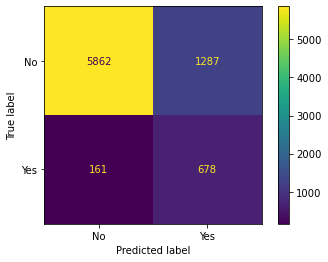

In [38]:
preds = lrsm.predict(X_test)
cm = confusion_matrix(y_test, preds)
ConfusionMatrixDisplay(cm, display_labels=['No', 'Yes']).plot();

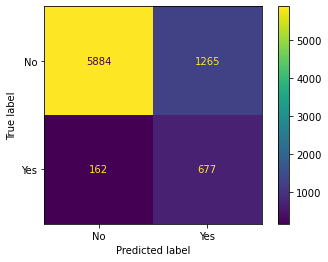

In [54]:
preds = lrsm.predict(X_test)
cm = confusion_matrix(y_test, preds)
ConfusionMatrixDisplay(cm, display_labels=['No', 'Yes']).plot();

In [55]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.97      0.82      0.89      7149
           1       0.35      0.81      0.49       839

    accuracy                           0.82      7988
   macro avg       0.66      0.81      0.69      7988
weighted avg       0.91      0.82      0.85      7988



In [56]:
lrsm.score(X_train_res, y_train_res), lrsm.score(X_test, y_test)

(0.8288878526463045, 0.82135703555333)

In [86]:
coef_df = pd.DataFrame({'coefs': lrsm.coef_[0], 'features': kb.get_support(indices=True)})
coef_df['feature_names'] = [X_dum.columns[i] for i in coef_df['features']] 
coef_df['questions'] = ['did not work last week', 'not on medicare', 'no pneumonia shot', 'blood sugar test w/i last year', 
                        'no rx last 12 months', 'health insurance not mentioned', 'no prediabetes', 'no heart disease', 
                        'no high cholesterol', 'no hypertension']
coef_df.drop(columns='features')

,coefs,feature_names,questions
0,0.341789,EMPWRKLSWK_A_2,did not work last week
1,0.057768,MEDICARE_A_3,not on medicare
2,-0.493950,SHTPNUEV_A_2,no pneumonia shot
3,1.452884,DIABLAST_A_1,blood sugar test w/i last year
4,-1.207990,RX12M_A_2,no rx last 12 months
5,-0.139947,HIKIND02_A_2,health insurance not mentioned
6,-2.428958,PREDIB_A_2,no prediabetes
7,-0.331133,CHDEV_A_2,no heart disease
8,-0.580376,CHLEV_A_2,no high cholesterol
9,-0.802246,HYPEV_A_2,no hypertension


In [58]:
prob_df = pd.DataFrame(X_test, index=y_test.index, columns=coef_df['feature_names'])
prob_df['prob_of_yes'] = [i[1] for i in lrsm.predict_proba(X_test)]
prob_df['predictions'] = lrsm.predict(X_test)
prob_df['actuals'] = y_test
prob_df['HHX'] = [survey['HHX'][index] for index in y_test.index]
prob_df.head()

feature_names,EMPWRKLSWK_A_2,MEDICARE_A_3,SHTPNUEV_A_2,DIABLAST_A_1,RX12M_A_2,HIKIND02_A_2,PREDIB_A_2,CHDEV_A_2,CHLEV_A_2,HYPEV_A_2,prob_of_yes,predictions,actuals,HHX
25452,0,0,0,1,0,0,1,1,0,0,0.573547,1,0,H030155
15107,0,1,1,1,1,1,1,1,1,1,0.053636,0,0,H010639
25379,0,1,1,1,1,1,1,1,1,1,0.053636,0,0,H004291
22130,0,1,1,1,0,1,0,1,1,1,0.682773,1,0,H007381
5108,0,1,1,1,0,1,1,1,1,1,0.159438,0,0,H010068


In [60]:
incorrect = prob_df[prob_df['predictions']!=prob_df['actuals']]
incorrect[incorrect['actuals']==1].sort_values('prob_of_yes')[-60:-30]

feature_names,EMPWRKLSWK_A_2,MEDICARE_A_3,SHTPNUEV_A_2,DIABLAST_A_1,RX12M_A_2,HIKIND02_A_2,PREDIB_A_2,CHDEV_A_2,CHLEV_A_2,HYPEV_A_2,prob_of_yes,predictions,actuals,HHX
20152,0,1,1,1,1,1,0,1,1,1,0.391396,0,1,H032659
20923,0,1,1,1,1,1,0,1,1,1,0.391396,0,1,H035496
10038,1,0,1,1,0,0,1,1,1,0,0.392647,0,1,H053960
12287,1,0,1,1,0,0,1,1,1,0,0.392647,0,1,H048835
28351,1,0,1,1,0,0,1,1,1,0,0.392647,0,1,H017654
4769,1,0,1,1,0,0,1,1,1,0,0.392647,0,1,H057532
31526,1,0,1,1,0,0,1,1,1,0,0.392647,0,1,H011150
14757,1,0,1,1,0,0,1,1,1,0,0.392647,0,1,H031261
26399,1,0,1,1,0,0,1,1,1,0,0.392647,0,1,H010899
1470,1,0,0,1,0,0,1,0,1,1,0.398106,0,1,H002250


In [85]:
# saving model
pickle.dump(lrsm, open('diabetes.p', 'wb'))

In [61]:
tree = DecisionTreeClassifier()
tree.fit(X_train_res, y_train_res)

DecisionTreeClassifier()

In [62]:
tree.score(X_train_res, y_train_res), tree.score(X_test, y_test)

(0.8429937048262999, 0.8237356034051077)

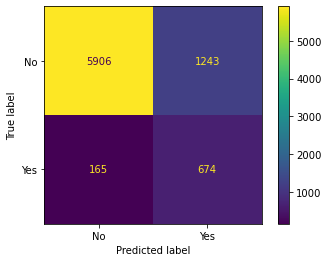

In [63]:
tpreds = tree.predict(X_test)
tcm = confusion_matrix(y_test, tpreds)
ConfusionMatrixDisplay(tcm, display_labels=['No', 'Yes']).plot();

In [65]:
print(classification_report(y_test, tpreds))

              precision    recall  f1-score   support

           0       0.97      0.83      0.89      7149
           1       0.35      0.80      0.49       839

    accuracy                           0.82      7988
   macro avg       0.66      0.81      0.69      7988
weighted avg       0.91      0.82      0.85      7988



In [82]:
ada = AdaBoostClassifier()
ada.fit(X_train_res, y_train_res)

AdaBoostClassifier()

In [83]:
ada.score(X_train_res, y_train_res), ada.score(X_test, y_test)

(0.8289111681044532, 0.8426389584376565)

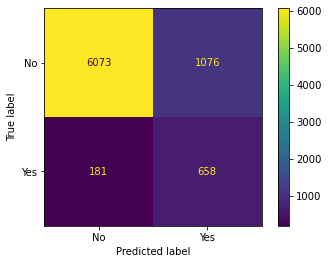

In [84]:
apreds = ada.predict(X_test)
acm = confusion_matrix(y_test, apreds)
ConfusionMatrixDisplay(acm, display_labels=['No', 'Yes']).plot();